## What is a Bland-Altman Plot?

A **Bland-Altman plot** (a.k.a. difference plot) assesses agreement between two measurement methods by plotting: 
- **X-axis**: Mean of the two methods: $(A + B) / 2$ 
- **Y-axis**: Difference: $A - B$ (or $B - A$, but stay consistent) 

Key overlays: 
- Mean difference (bias) line 
- Limits of agreement (LoA): bias ± 1.96 · SD of differences (assuming normality) 

Use cases: method comparison, sensor validation, model vs. reference, lab vs. field measurements.

## How to Read the Plot
- **Centered cloud near zero**: Good agreement, minimal bias.
- **Non-zero mean difference**: Systematic bias (one method consistently higher/lower).
- **Slope/trend in differences vs. mean**: Proportional bias (disagreement changes with magnitude).
- **Widening spread with magnitude**: Heteroscedasticity (variance increases with size).
- **Outliers beyond LoA**: Poor agreement for specific cases.
- **Wide LoA**: High variability; methods disagree too much for practical use.

## Scenarios Covered
1. **Ideal agreement** (no bias, homoscedastic)
2. **Constant bias** (one method always higher/lower)
3. **Proportional bias** (difference grows with magnitude)
4. **Heteroscedasticity** (variance grows with magnitude)
5. **Outliers** (a few large disagreements)

### Heteroscedasticity Example (Variance Increases with Magnitude)
- Scenario: Spread of differences grows as the mean increases.
- Plot signature: Funnel shape—narrow at low means, wide at high means.
- Practical meaning: Measurement error grows with signal size; a single LoA band may understate uncertainty at the high end.
- Remedies:
  - Apply log transform and re-run Bland-Altman.
  - Model proportional error (e.g., regression of diff vs. mean).
  - Report LoA on transformed scale or use percentage differences.


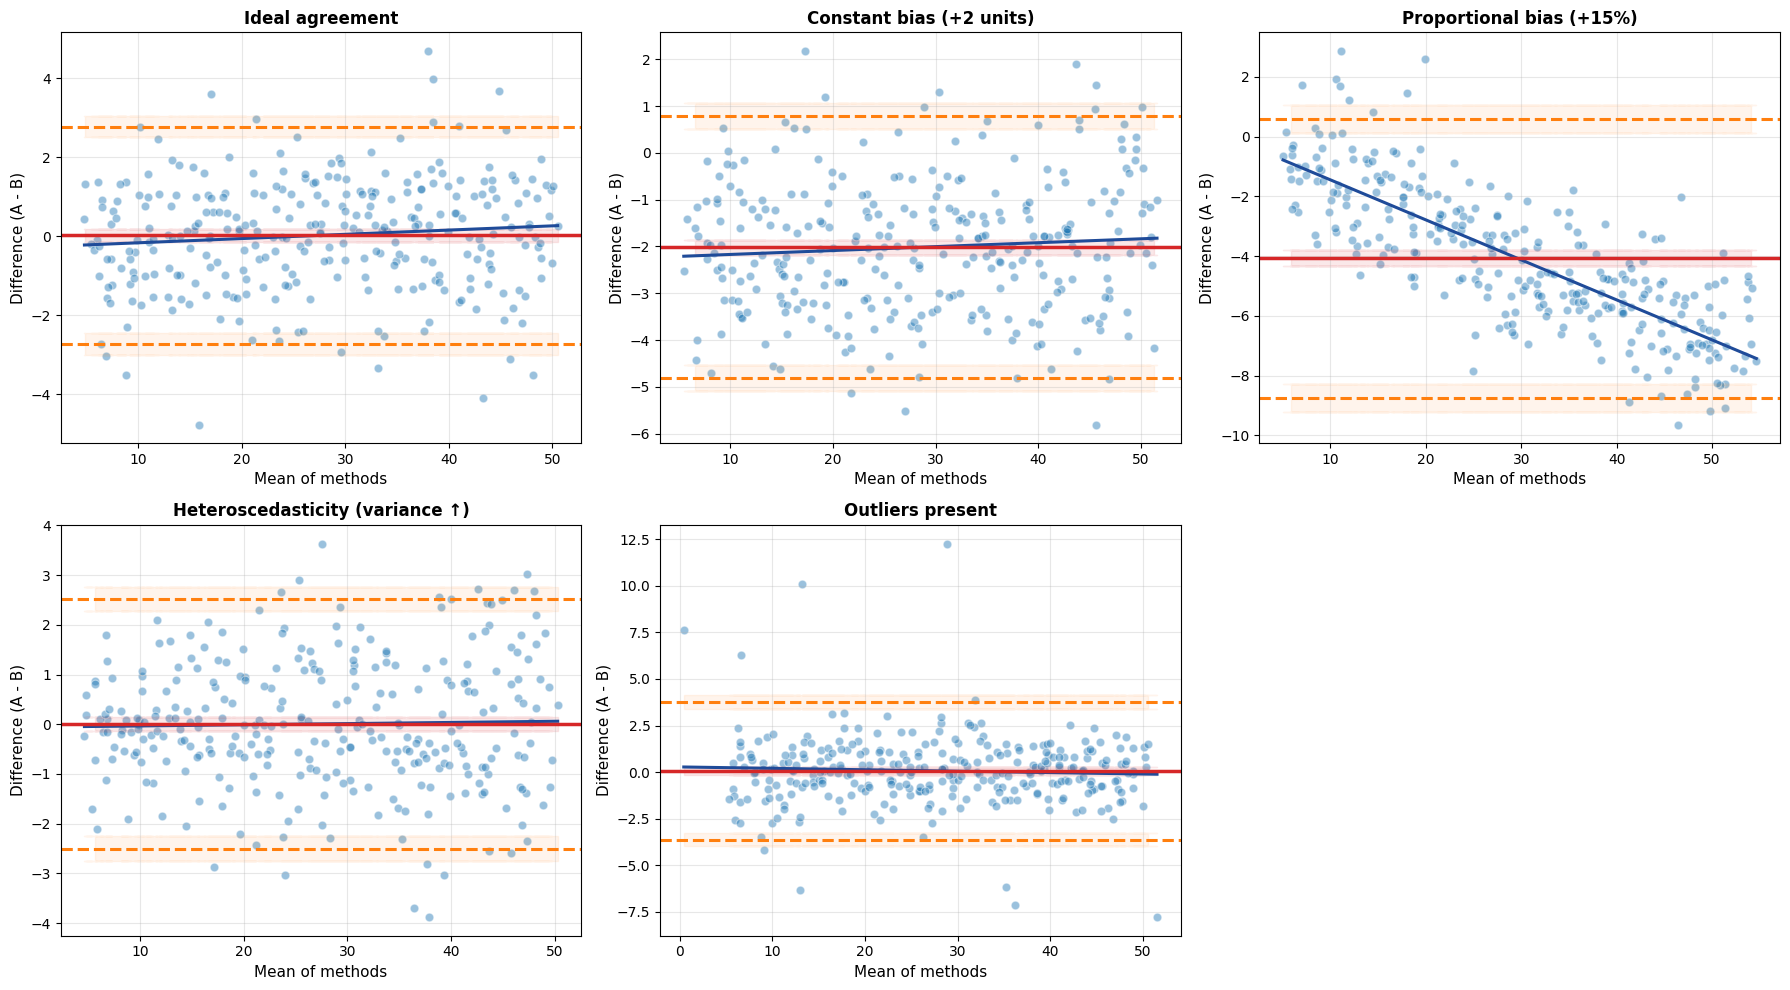

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

np.random.seed(42)
n = 300


def bland_altman_data(base, bias=0.0, slope=0.0, noise=1.0, hetero=False, outliers=0, hetero_scale=0.8):
    true = base
    method_a = true + norm.rvs(scale=noise, size=true.size)
    method_b = true * (1 + slope) + bias + norm.rvs(
        scale=noise * (1 + hetero_scale * hetero * (true / true.max())), size=true.size
    )
    if outliers > 0:
        idx = np.random.choice(true.size, outliers, replace=False)
        method_b[idx] += np.random.choice([-1, 1], size=outliers) * np.random.uniform(5, 12, size=outliers)
    return method_a, method_b


def bland_altman_plot(a, b, ax, title):
    mean = (a + b) / 2
    diff = a - b
    n_obs = diff.size
    bias = np.mean(diff)
    sd = np.std(diff, ddof=1)

    # Limits of agreement
    loa_upper = bias + 1.96 * sd
    loa_lower = bias - 1.96 * sd

    # 95% CI for bias and LoA (Bland & Altman 1999)
    t_crit = t.ppf(0.975, n_obs - 1)
    bias_ci_half = t_crit * sd / np.sqrt(n_obs)
    loa_ci_half = t_crit * sd * np.sqrt(1 / n_obs + (1.96**2) / (2 * (n_obs - 1)))

    bias_ci = (bias - bias_ci_half, bias + bias_ci_half)
    loa_upper_ci = (loa_upper - loa_ci_half, loa_upper + loa_ci_half)
    loa_lower_ci = (loa_lower - loa_ci_half, loa_lower + loa_ci_half)

    # Larger, clearer visuals
    ax.scatter(mean, diff, alpha=0.45, s=38, color='#1f77b4', edgecolor='white', linewidth=0.8)

    # Trend line (diff vs mean) to highlight proportional bias
    fit_slope, fit_intercept = np.polyfit(mean, diff, 1)
    line_x = np.linspace(mean.min(), mean.max(), 60)
    line_y = fit_slope * line_x + fit_intercept
    ax.plot(line_x, line_y, color='#1f4b99', linewidth=2.2, label='Trend (diff~mean)')

    # Bias line and CI band
    ax.axhline(bias, color='#d62728', linestyle='-', linewidth=2.5, label=f'Bias = {bias:.2f}')
    ax.fill_between(mean, bias_ci[0], bias_ci[1], color='#d62728', alpha=0.10, label='Bias 95% CI')

    # Limits of agreement and CI bands
    ax.axhline(loa_upper, color='#ff7f0e', linestyle='--', linewidth=2.2, label='LoA')
    ax.axhline(loa_lower, color='#ff7f0e', linestyle='--', linewidth=2.2)
    ax.fill_between(mean, loa_upper_ci[0], loa_upper_ci[1], color='#ff7f0e', alpha=0.08, label='LoA 95% CI')
    ax.fill_between(mean, loa_lower_ci[0], loa_lower_ci[1], color='#ff7f0e', alpha=0.08)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Mean of methods', fontsize=11)
    ax.set_ylabel('Difference (A - B)', fontsize=11)
    ax.grid(True, alpha=0.3)


# Generate scenarios
base = np.linspace(5, 50, n)
scenarios = [
    ('Ideal agreement',                 dict(bias=0.0, slope=0.0,  noise=1.0, hetero=False, outliers=0, hetero_scale=0.8)),
    ('Constant bias (+2 units)',        dict(bias=2.0, slope=0.0,  noise=1.0, hetero=False, outliers=0, hetero_scale=0.8)),
    # Increased slope so proportional bias trend is obvious
    ('Proportional bias (+15%)',        dict(bias=0.0, slope=0.15, noise=1.0, hetero=False, outliers=0, hetero_scale=0.8)),
    # Stronger heteroscedasticity for clearer funnel shape
    ('Heteroscedasticity (variance ↑)', dict(bias=0.0, slope=0.0,  noise=0.6, hetero=True,  outliers=0, hetero_scale=1.6)),
    ('Outliers present',                dict(bias=0.0, slope=0.0,  noise=1.0, hetero=False, outliers=8, hetero_scale=0.8)),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (title, cfg) in zip(axes, scenarios):
    a, b = bland_altman_data(base, **cfg)
    bland_altman_plot(a, b, ax, title)

# Hide the empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()


## Limits of Agreement Confidence Intervals

We add 95% confidence intervals (CIs) around the bias and the limits of agreement (LoA):

- **Bias CI (mean difference):** $\text{bias} \pm t_{0.975, n-1} \cdot \dfrac{\text{SD}}{\sqrt{n}}$
- **LoA CI:** $\text{LoA} \pm t_{0.975, n-1} \cdot \text{SD} \cdot \sqrt{\dfrac{1}{n} + \dfrac{1.96^2}{2 (n-1)}}$

**Interpretation:**
- The bias CI shows uncertainty of the average difference.
- The LoA CIs show uncertainty of the 95% limits; wider bands mean less precision in agreement estimates.
- If many points lie outside the LoA CI, agreement is poor or assumptions may be violated.
